<h2 align=center> Classify Radio Signals from Outer Space with Keras</h2>

![](Allen_Telescope.jpg)
[Allen Telescope Array](https://flickr.com/photos/93452909@N00/5656086917) by [brewbooks](https://www.flickr.com/people/93452909@N00) is licensed under [CC BY 2.0](https://creativecommons.org/licenses/by/2.0/)

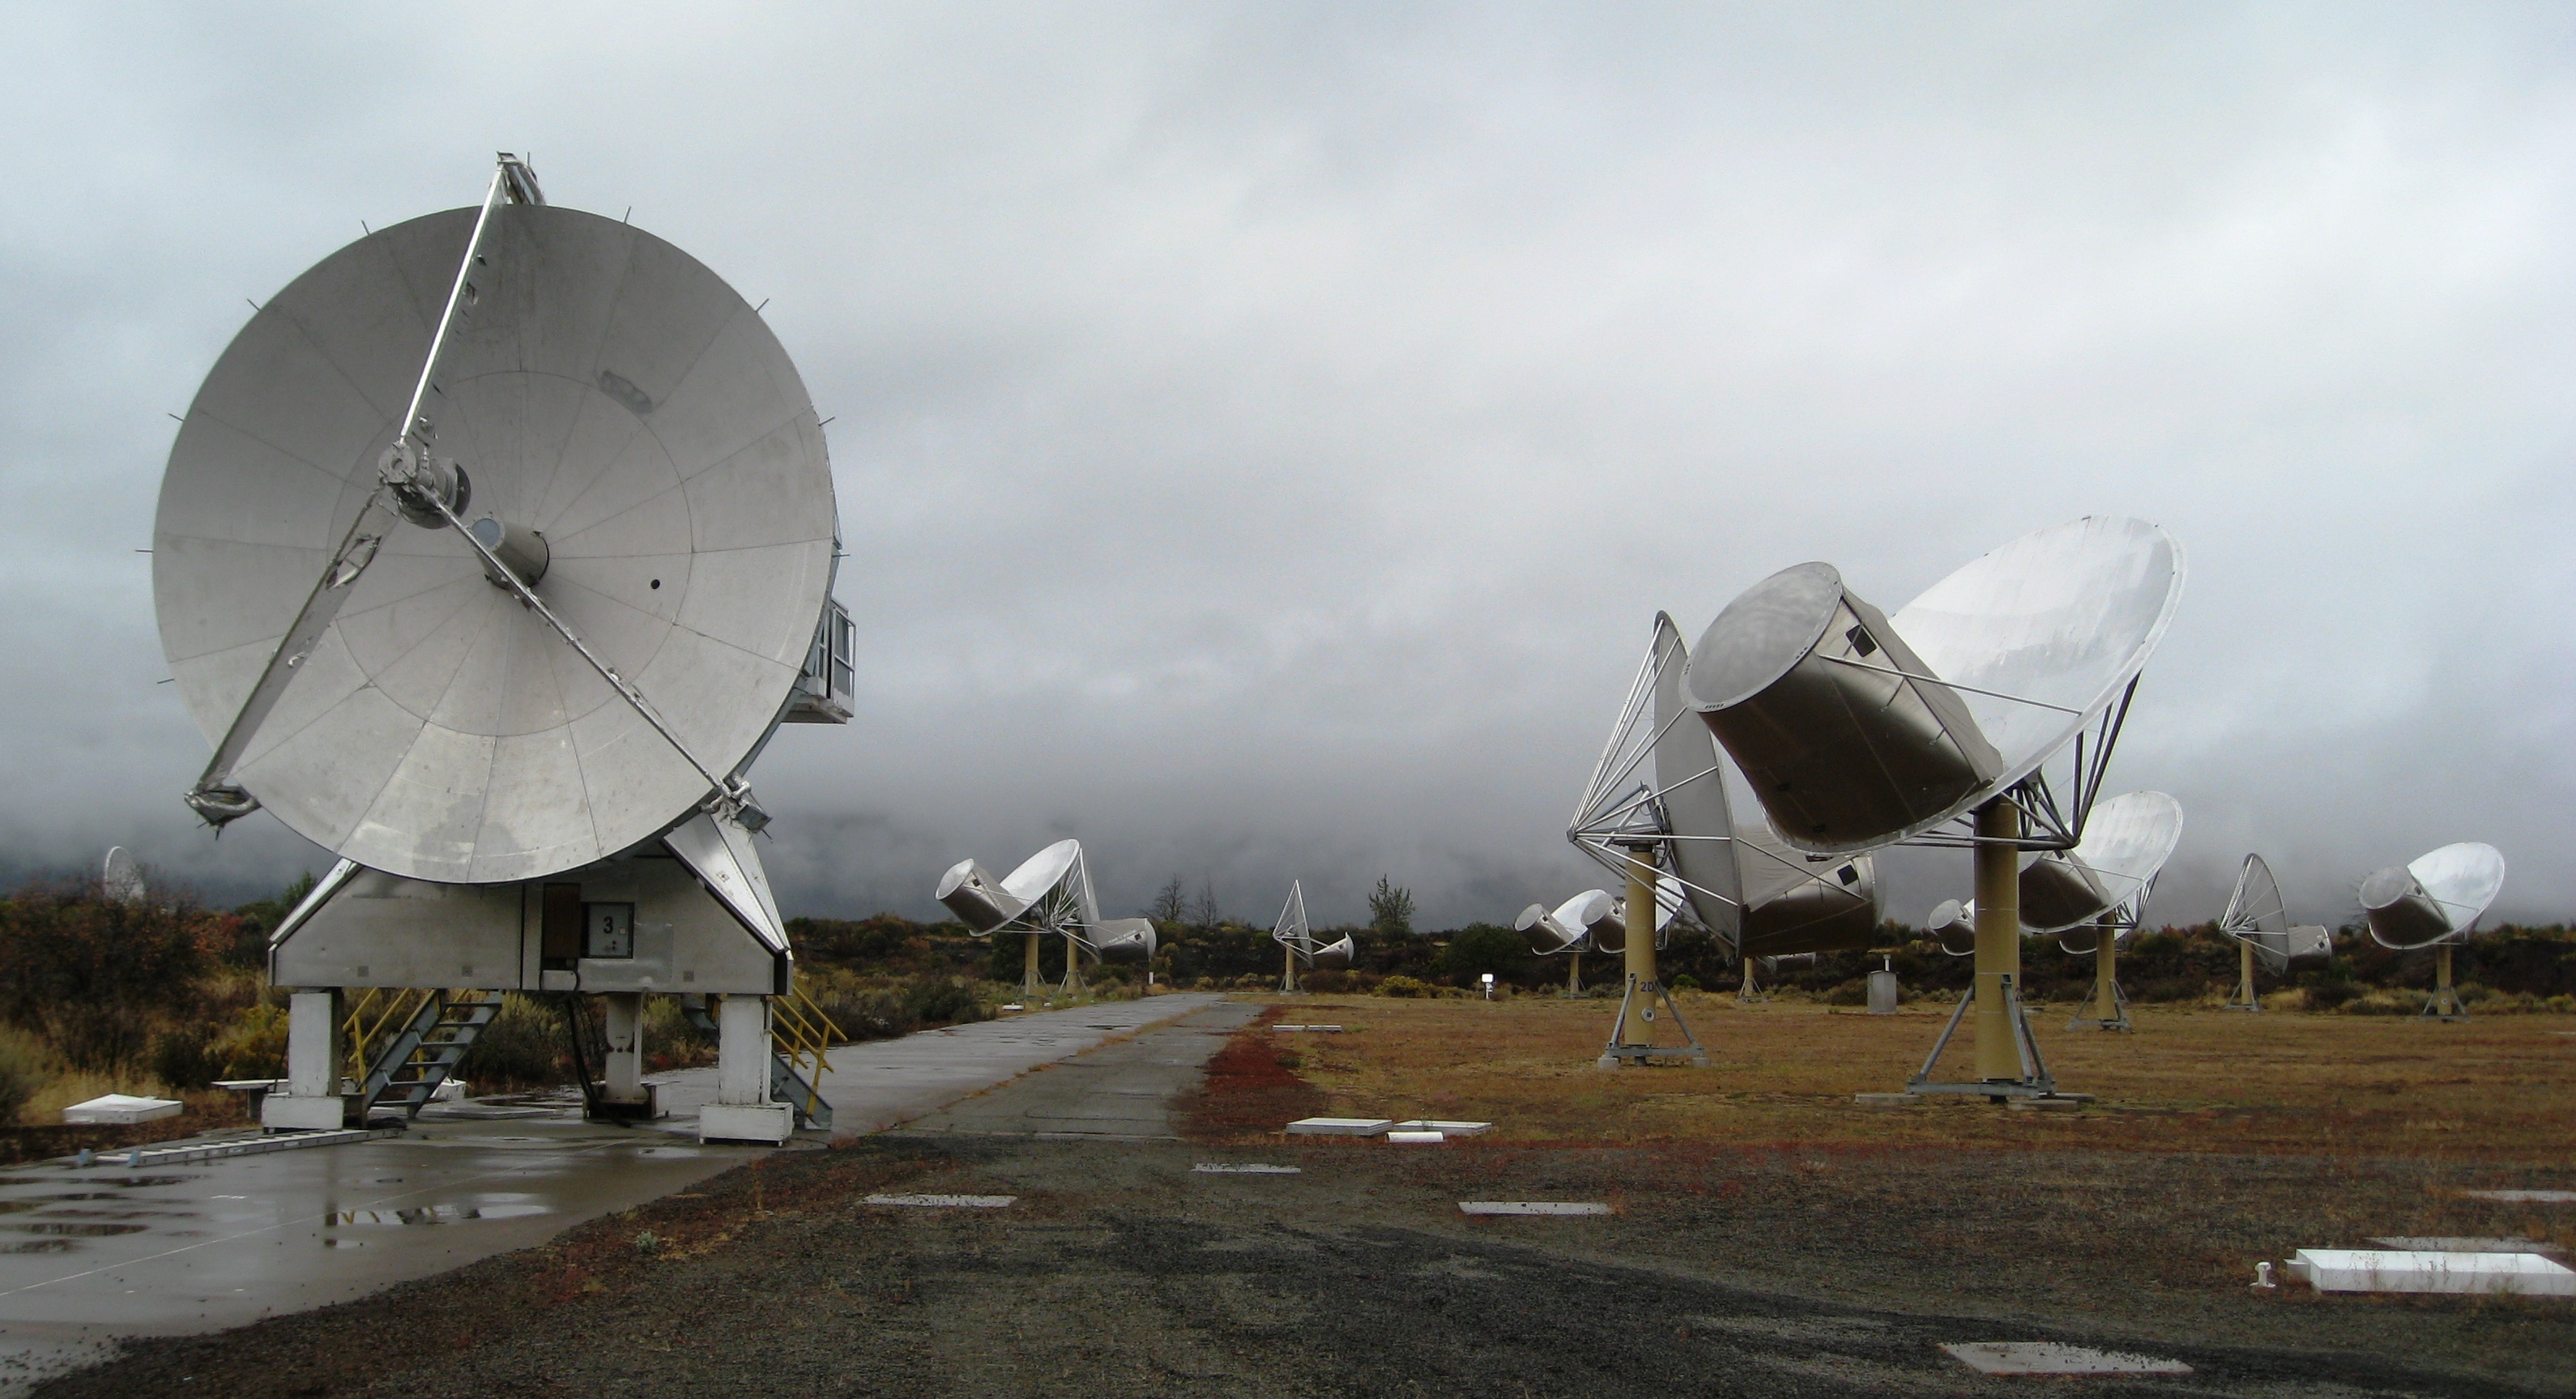

##Import Libraries

In [2]:
!pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip uninstall tensorflow==2.3.0
!pip install tensorflow-gpu==2.1.0
import tensorflow as tf
if tf.test.gpu_device_name(): 

    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

else:

   print("Please install GPU version of TF")

from sklearn.metrics import confusion_matrix
from sklearn import metrics

import numpy as np
np.random.seed(42)
import warnings;warnings.simplefilter('ignore')
%matplotlib inline
print('Tensorflow version:', tf.__version__)

Default GPU Device:/device:GPU:0
Tensorflow version: 2.1.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Task 2: Load and Preprocess SETI Data

In [4]:
train_images = pd.read_csv("/content/drive/My Drive/CRSOS/dataset/train/images.csv",header=None)
train_lables = pd.read_csv("/content/drive/My Drive/CRSOS/dataset/train/labels.csv",header=None)

val_images = pd.read_csv("/content/drive/My Drive/CRSOS/dataset/validation/images.csv",header=None)
val_lables = pd.read_csv("/content/drive/My Drive/CRSOS/dataset/validation/labels.csv",header=None)

In [5]:
train_images.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,8152,8153,8154,8155,8156,8157,8158,8159,8160,8161,8162,8163,8164,8165,8166,8167,8168,8169,8170,8171,8172,8173,8174,8175,8176,8177,8178,8179,8180,8181,8182,8183,8184,8185,8186,8187,8188,8189,8190,8191
0,0.631373,0.623529,0.713726,0.705882,0.658824,0.666667,0.654902,0.635294,0.647059,0.705882,0.729412,0.725490,0.619608,0.674510,0.643137,0.705882,0.713726,0.658824,0.615686,0.690196,0.654902,0.525490,0.556863,0.541176,0.482353,0.588235,0.615686,0.600000,0.603922,0.627451,0.678431,0.658824,0.698039,0.576471,0.678431,0.686275,0.690196,0.705882,0.705882,0.643137,...,0.650980,0.666667,0.666667,0.709804,0.682353,0.682353,0.682353,0.658824,0.682353,0.643137,0.627451,0.623529,0.650980,0.721569,0.627451,0.635294,0.709804,0.690196,0.678431,0.647059,0.658824,0.682353,0.654902,0.694118,0.741176,0.678431,0.662745,0.729412,0.694118,0.647059,0.682353,0.611765,0.650980,0.658824,0.600000,0.603922,0.654902,0.694118,0.658824,0.666667
1,0.725490,0.752941,0.749020,0.701961,0.690196,0.721569,0.709804,0.745098,0.654902,0.721569,0.678431,0.709804,0.713726,0.686275,0.717647,0.713726,0.694118,0.690196,0.721569,0.701961,0.698039,0.713726,0.705882,0.756863,0.756863,0.694118,0.650980,0.674510,0.752941,0.725490,0.725490,0.760784,0.678431,0.717647,0.725490,0.682353,0.709804,0.729412,0.721569,0.717647,...,0.686275,0.670588,0.713726,0.733333,0.725490,0.694118,0.694118,0.686275,0.674510,0.729412,0.721569,0.701961,0.682353,0.709804,0.756863,0.698039,0.729412,0.721569,0.674510,0.698039,0.725490,0.733333,0.666667,0.682353,0.701961,0.737255,0.745098,0.725490,0.698039,0.650980,0.721569,0.698039,0.721569,0.686275,0.713726,0.682353,0.690196,0.698039,0.701961,0.725490
2,0.717647,0.701961,0.713726,0.733333,0.705882,0.717647,0.725490,0.682353,0.717647,0.674510,0.690196,0.670588,0.662745,0.666667,0.713726,0.701961,0.721569,0.713726,0.662745,0.698039,0.682353,0.639216,0.717647,0.658824,0.674510,0.639216,0.643137,0.635294,0.654902,0.682353,0.639216,0.733333,0.690196,0.658824,0.686275,0.658824,0.690196,0.698039,0.709804,0.650980,...,0.533333,0.572549,0.537255,0.549020,0.670588,0.690196,0.670588,0.643137,0.662745,0.713726,0.717647,0.721569,0.709804,0.674510,0.709804,0.686275,0.658824,0.694118,0.698039,0.694118,0.678431,0.678431,0.690196,0.662745,0.650980,0.650980,0.686275,0.631373,0.666667,0.701961,0.709804,0.694118,0.705882,0.682353,0.639216,0.713726,0.670588,0.678431,0.737255,0.674510
3,0.705882,0.674510,0.654902,0.678431,0.666667,0.662745,0.678431,0.662745,0.686275,0.686275,0.631373,0.650980,0.670588,0.737255,0.674510,0.615686,0.670588,0.705882,0.686275,0.678431,0.694118,0.647059,0.662745,0.682353,0.654902,0.721569,0.709804,0.631373,0.670588,0.674510,0.701961,0.725490,0.666667,0.647059,0.733333,0.682353,0.678431,0.603922,0.666667,0.713726,...,0.670588,0.705882,0.749020,0.662745,0.564706,0.623529,0.674510,0.709804,0.658824,0.631373,0.705882,0.670588,0.658824,0.690196,0.674510,0.658824,0.635294,0.682353,0.682353,0.639216,0.666667,0.654902,0.647059,0.670588,0.682353,0.639216,0.705882,0.729412,0.674510,0.666667,0.639216,0.662745,0.631373,0.643137,0.705882,0.662745,0.705882,0.666667,0.654902,0.631373
4,0.647059,0.729412,0.701961,0.674510,0.611765,0.698039,0.713726,0.662745,0.701961,0.674510,0.631373,0.709804,0.694118,0.698039,0.666667,0.690196,0.690196,0.682353,0.682353,0.647059,0.678431,0.658824,0.760784,0.729412,0.674510,0.694118,0.698039,0.713726,0.690196,0.698039,0.686275,0.705882,0.662745,0.670588,0.705882,0.682353,0.690196,0.733333,0.709804,0.701961,...,0.639216,0.690196,0.662745,0.658824,0.662745,0.698039,0.603922,0.690196,0.627451,0.627451,0.654902,0.725490,0.650980,0.717647,0.666667,0.709804,0.682353,0.674510,0.721569,0.741176,0.635294,0.615686,0.674510,0.690196,0.658824,0.694118,0.701961,0.670588,0.721569,0.780392,0.639216,0.670588,0.705882,0.674510,0.721569,0.694118,0.674510,0.705882,0.749020,0.729412


In [6]:
train_lables.head()

,0,1,2,3
0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0


In [7]:
val_images.head()
val_images.shape

(800, 8192)

In [8]:
val_lables.head()
val_lables.shape

(800, 4)

In [9]:
x_train = train_images.values.reshape(3200,64,128,1)
x_val = val_images.values.reshape(800,64,128,1)

y_train = train_lables.values
y_val =val_lables.values

## Task 3: Plot 2D Spectrograms

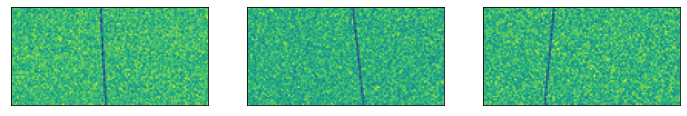

In [10]:
plt.figure(0,figsize=(12,12))
for i in range(1,4):
  plt.subplot(1,3,i)
  img = np.squeeze(x_train[np.random.randint(0,x_train.shape[0])])
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img)

## Task 4: Create Training and Validation Data Generators

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dg = ImageDataGenerator(horizontal_flip=True)
train_dg.fit(x_train)

val_dg = ImageDataGenerator(horizontal_flip=True)
val_dg.fit(x_val)

## Task 5: Creating the CNN Model

In [12]:
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint

In [28]:
# Initialising the CNN
model = Sequential()
# 1st Convolution
model.add(Conv2D(32,(5,5),padding='same',input_shape=(64,128,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(64,(5,5),padding='same'))
# Flattening
model.add(Flatten())
# Fully connected layer
model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.4))

#output layer
model.add(Dense(4,activation='softmax'))

In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 64, 128, 32)       832       
_________________________________________________________________
batch_normalization_4 (Batch (None, 64, 128, 32)       128       
_________________________________________________________________
activation_4 (Activation)    (None, 64, 128, 32)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 64, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 32, 64, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 64, 64)        51264     
_________________________________________________________________
flatten_2 (Flatten)          (None, 131072)           

## Task 6: Learning Rate Scheduling and Compile the Model

In [30]:
initial_learning_rate=0.005
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = initial_learning_rate,
    decay_steps=5,
    decay_rate=0.96,
    staircase=True
)
optimizer=Adam(learning_rate=lr_schedule)

In [31]:
model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

## Task 7: Training the Model

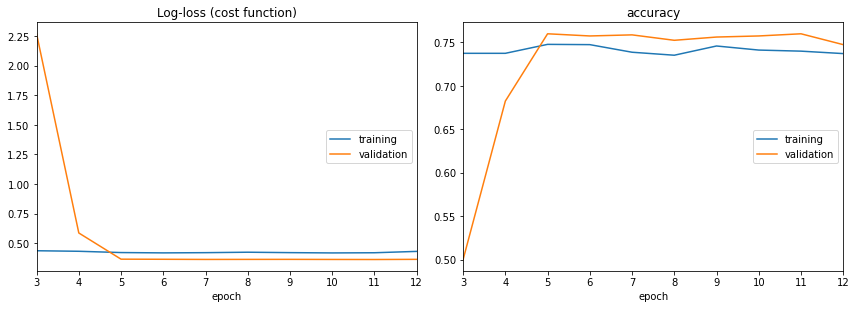

Log-loss (cost function):
training   (min:    0.418, max:    0.634, cur:    0.431)
validation (min:    0.363, max:    7.189, cur:    0.364)

accuracy:
training   (min:    0.697, max:    0.748, cur:    0.737)
validation (min:    0.250, max:    0.760, cur:    0.748)
200/200 [==============================] - 15s 73ms/step - loss: 0.4312 - accuracy: 0.7372 - val_loss: 0.3640 - val_accuracy: 0.7475


In [32]:
checkpoint = ModelCheckpoint('model.h5',monitor='val_loss',save_weights_only=True,mode='min',verbose=0)
callbacks = [PlotLossesCallback(),checkpoint]

batch_size = 16

history = model.fit(train_dg.flow(x_train,y_train,batch_size=batch_size,shuffle=True),
                    steps_per_epoch=len(x_train)//batch_size,validation_data=val_dg.flow(x_val,y_val,batch_size=batch_size,shuffle=True),
                    validation_steps = len(x_val)//batch_size,epochs=12,callbacks=callbacks)


## Task 8: Model Evaluation

In [33]:
model.evaluate(x_val,y_val)

800/800 [==============================] - 0s 465us/sample - loss: 0.3634 - accuracy: 0.7588


[0.36338231203146276, 0.75875]

In [37]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import seaborn as sns

y_true = np.argmax(y_val,1)
y_pred = np.argmax(model.predict(x_val),1)
print(metrics.classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       200
           1       0.51      0.72      0.60       200
           2       0.53      0.32      0.40       200
           3       1.00      1.00      1.00       200

    accuracy                           0.76       800
   macro avg       0.76      0.76      0.75       800
weighted avg       0.76      0.76      0.75       800

